## Area under the receiver operating curve

Copyright 2019 Allen Downey

License: http://creativecommons.org/licenses/by/4.0/

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

### Area under ROC

As a way of understanding AUC ROC, let's look at the relationship between AUC and Cohen's effect size.

Cohen's effect size, `d`, expresses the difference between two groups as the number of standard deviations between the means.

As `d` increases, we expect it to be easier to distinguish between groups, so we expect AUC to increase.

I'll start in one dimension and then generalize to multiple dimensions.a

Here are the means and standard deviations for two hypothetical groups.

In [2]:
mu1 = 0
sigma = 1

d = 1
mu2 = mu1 + d;

I'll generate two random samples with these parameters.

In [3]:
n = 1000
sample1 = np.random.normal(mu1, sigma, n)
sample2 = np.random.normal(mu2, sigma, n);

If we put a threshold at the midpoint between the means, we can compute the fraction of Group 0 that would be above the threshold.

I'll call that the false positive rate.

In [4]:
thresh = (mu1 + mu2) / 2
np.mean(sample1 > thresh)

0.301

And here's the fraction of Group 1 that would be below the threshold, which I'll call the false negative rate.

In [5]:
np.mean(sample2 < thresh)

0.325

### Plotting misclassification

To see what these overlapping distributions look like, I'll plot a kernel density estimate (KDE).

In [6]:
from scipy.stats import gaussian_kde

def make_kde(sample):
    """Kernel density estimate.
    
    sample: sequence
    
    returns: Series
    """
    xs = np.linspace(-4, 4, 101)
    kde = gaussian_kde(sample)
    ys = kde.evaluate(xs)
    return pd.Series(ys, index=xs)

In [7]:
def plot_kde(kde, clipped, color):
    """Plot a KDE and fill under the clipped part.
    
    kde: Series
    clipped: Series
    color: string
    """
    plt.plot(kde.index, kde, color=color)
    plt.fill_between(clipped.index, clipped, color=color, alpha=0.3)

In [8]:
def plot_misclassification(sample1, sample2, thresh):
    """Plot KDEs and shade the areas of misclassification.
    
    sample1: sequence
    sample2: sequence
    thresh: number
    """
    kde1 = make_kde(sample1)
    clipped = kde1[kde1.index>=thresh]
    plot_kde(kde1, clipped, 'C0')

    kde2 = make_kde(sample2)
    clipped = kde2[kde2.index<=thresh]
    plot_kde(kde2, clipped, 'C1')

Here's what it looks like with the threshold at 0.  There are many false positives, shown in blue, and few false negatives, in orange.

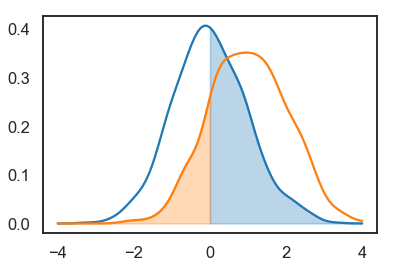

In [9]:
plot_misclassification(sample1, sample2, 0)

With a higher threshold, we get fewer false positives, at the cost of more false negatives.

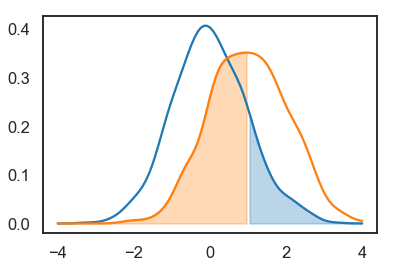

In [10]:
plot_misclassification(sample1, sample2, 1)

### The receiver operating curve

The receiver operating curve (ROC) represents this tradeoff.

To plot the ROC, we have to compute the false positive rate (which we saw in the figure above), and the true positive rate (not shown in the figure).

The following function computes these metrics.

In [11]:
def fpr_tpr(sample1, sample2, thresh):
    """Compute false positive and true positive rates.
    
    sample1: sequence
    sample2: sequence
    thresh: number
    
    returns: tuple of (fpr, tpf)
    """
    fpr = np.mean(sample1>thresh)
    tpr = np.mean(sample2>thresh)
    return fpr, tpr

When the threshold is high, the false positive rate is low, but so is the true positive rate.

In [12]:
fpr_tpr(sample1, sample2, 1)

(0.15, 0.501)

As we decrease the threshold, the true positive rate increases, but so does the false positive rate.

In [13]:
fpr_tpr(sample1, sample2, 0)

(0.483, 0.846)

The ROC shows this tradeoff over a range of thresholds.

I sweep thresholds from high to low so the ROC goes from left to right.

In [14]:
from scipy.integrate import trapz

def plot_roc(sample1, sample2, label):
    """Plot the ROC curve and return the AUC.
    
    sample1: sequence
    sample2: sequence
    label: string
    
    returns: AUC
    """
    threshes = np.linspace(5, -3)
    roc = [fpr_tpr(sample1, sample2, thresh)
          for thresh in threshes]

    fpr, tpr = np.transpose(roc)
    plt.plot(fpr, tpr, label=label)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    auc = trapz(tpr, fpr)
    return auc

Here's the ROC for the samples.

With `d=1`, the area under the curve is about 0.75.  That might be a good number to remember.

0.761592

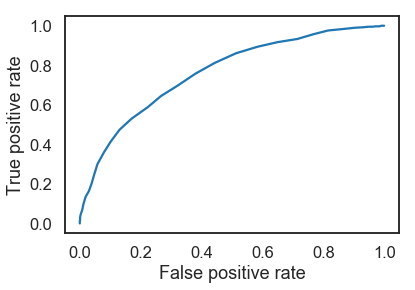

In [15]:
auc = plot_roc(sample1, sample2, '')

Now let's see what that looks like for a range of `d`.

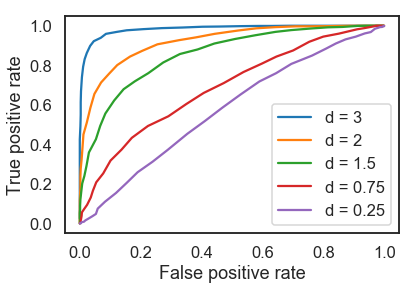

In [16]:
mu1 = 0
sigma = 1
n = 1000

res = []
for mu2 in [3, 2, 1.5, 0.75, 0.25]:
    sample1 = np.random.normal(mu1, sigma, n)
    sample2 = np.random.normal(mu2, sigma, n)
    
    d = (mu2-mu1) / sigma
    label = 'd = %0.2g' % d
    auc = plot_roc(sample1, sample2, label)
    res.append((d, auc))
    
plt.legend();

This function computes AUC as a function of `d`.

In [17]:
def plot_auc_vs_d(res, label):
    d, auc = np.transpose(res)
    plt.plot(d, auc, label=label, alpha=0.8)
    plt.xlabel('Cohen effect size')
    plt.ylabel('Area under ROC')

The following figure shows AUC as a function of `d`.

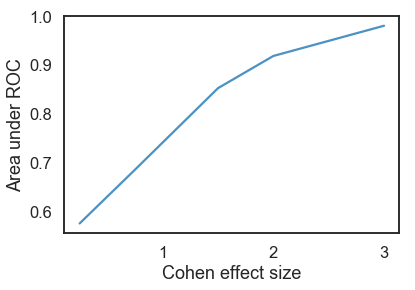

In [18]:
plot_auc_vs_d(res, '')

Not suprisingly, AUC increases as `d` increases.

### Multivariate distributions

Now let's see what happens if we have more than one variable, with a difference in means along more than one dimension.

First, I'll generate a 2-D sample with `d=1` along both dimensions.

In [19]:
from scipy.stats import multivariate_normal

d = 1
mu1 = [0, 0]
mu2 = [d, d]

rho = 0
sigma = [[1, rho], [rho, 1]]

[[1, 0], [0, 1]]

In [20]:
sample1 = multivariate_normal(mu1, sigma).rvs(n)
sample2 = multivariate_normal(mu2, sigma).rvs(n);

The mean of `sample1` should be near 0 for both features.

In [21]:
np.mean(sample1, axis=0)

array([ 0.01204411, -0.05193738])

And the mean of `sample2` should be near 1.

In [22]:
np.mean(sample2, axis=0)

array([0.97947675, 1.02358947])

The following scatterplot shows what this looks like in 2-D.

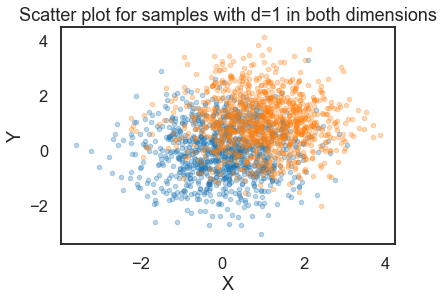

In [23]:
x, y = sample1.transpose()
plt.plot(x, y, '.', alpha=0.3)

x, y = sample2.transpose()
plt.plot(x, y, '.', alpha=0.3)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot for samples with d=1 in both dimensions');

Some points are clearly classifiable, but there is substantial overlap in the distributions.



We can see the same thing if we estimate a 2-D density function and make a contour plot.

In [24]:
# Based on an example at https://plot.ly/ipython-notebooks/2d-kernel-density-distributions/

def kde_scipy(sample):
    """Use KDE to compute an array of densities.
    
    sample: sequence
    
    returns: tuple of matrixes, (X, Y, Z)
    """
    x = np.linspace(-4, 4)
    y = x
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([Y.ravel(), X.ravel()])

    kde = gaussian_kde(sample.T)
    kde(positions)
    Z = np.reshape(kde(positions).T, X.shape)

    return [X, Y, Z]

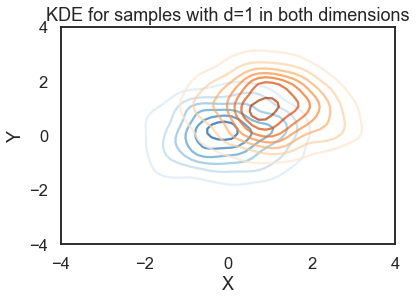

In [25]:
X, Y, Z = kde_scipy(sample1) 
plt.contour(X, Y, Z, cmap=plt.cm.Blues, alpha=0.7)

X, Y, Z = kde_scipy(sample2) 
plt.contour(X, Y, Z, cmap=plt.cm.Oranges, alpha=0.7)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('KDE for samples with d=1 in both dimensions');

### Classification with logistic regression

To see how distinguishable the samples are, I'll use logistic regression.

To get the data into the right shape, I'll make two DataFrames, label them, concatenate them, and then extract the labels and the features. 

In [26]:
df1 = pd.DataFrame(sample1)
df1['label'] = 1
df1.describe()

,0,1,label
count,1000.000000,1000.000000,1000.0
mean,0.012044,-0.051937,1.0
std,0.971861,0.976814,0.0
min,-3.580857,-3.061129,1.0
25%,-0.596927,-0.696824,1.0
50%,0.071937,-0.044057,1.0
75%,0.655457,0.615113,1.0
max,3.053507,3.292066,1.0


In [27]:
df1[[0,1]].corr()

,0,1
0,1.000000,0.021376
1,0.021376,1.000000


In [28]:
df2 = pd.DataFrame(sample2)
df2['label'] = 2
df2.describe()

,0,1,label
count,1000.000000,1000.000000,1000.0
mean,0.979477,1.023589,2.0
std,0.983136,0.967058,0.0
min,-2.231272,-2.027548,2.0
25%,0.291482,0.417082,2.0
50%,1.008545,1.008277,2.0
75%,1.670930,1.647037,2.0
max,3.869119,4.138071,2.0


In [29]:
df2[[0,1]].corr()

,0,1
0,1.00000,-0.04433
1,-0.04433,1.00000


In [30]:
df = pd.concat([df1, df2], ignore_index=True)
df.label.value_counts()

2    1000
1    1000
Name: label, dtype: int64

`X` is the array of features; `y` is the vector of labels.

In [31]:
X = df[[0, 1]]
y = df.label;

Now we can fit the model.

In [32]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs').fit(X, y);

And compute the AUC.

In [33]:
from sklearn.metrics import roc_auc_score

y_pred_prob = model.predict_proba(X)[:,1]
auc = roc_auc_score(y, y_pred_prob)

0.853391

With two features, we can do better than with just one.



### AUC as a function of rho

The following function contains the code from the previous section, with `rho` as a parameter.

In [34]:
def multivariate_normal_auc(d, rho=0):
    """Generate multivariate normal samples and classify them.
    
    d: Cohen's effect size along each dimension
    num_dims: number of dimensions
    
    returns: AUC
    """
    mu1 = [0, 0]
    mu2 = [d, d]

    sigma = [[1, rho], [rho, 1]]

    # generate the samples
    sample1 = multivariate_normal(mu1, sigma).rvs(n)
    sample2 = multivariate_normal(mu2, sigma).rvs(n)

    # label the samples and extract the features and labels
    df1 = pd.DataFrame(sample1)
    df1['label'] = 1

    df2 = pd.DataFrame(sample2)
    df2['label'] = 2

    df = pd.concat([df1, df2], ignore_index=True)

    X = df.drop(columns='label')
    y = df.label
    
    # run the model
    model = LogisticRegression(solver='lbfgs').fit(X, y)
    y_pred_prob = model.predict_proba(X)[:,1]

    # compute AUC
    auc = roc_auc_score(y, y_pred_prob)
    return auc

Now we can sweep a range of values for `rho`.

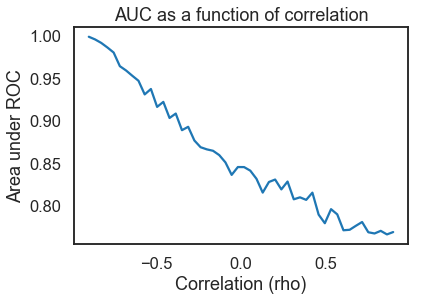

In [35]:
res = [(rho, multivariate_normal_auc(d=1, rho=rho))
       for rho in np.linspace(-0.9, 0.9)]

rhos, aucs = np.transpose(res)
plt.plot(rhos, aucs)
plt.xlabel('Correlation (rho)')
plt.ylabel('Area under ROC')
plt.title('AUC as a function of correlation');

### AUC as a function of d

The following function contains the code from the previous section, generalized to handle more than 2 dimensions.

In [36]:
def multivariate_normal_auc(d, num_dims=2):
    """Generate multivariate normal samples and classify them.
    
    d: Cohen's effect size along each dimension
    num_dims: number of dimensions
    
    returns: AUC
    """
    # compute the mus
    mu1 = np.zeros(num_dims)
    mu2 = np.full(num_dims, d)

    # and sigma
    sigma = np.identity(num_dims)

    # generate the samples
    sample1 = multivariate_normal(mu1, sigma).rvs(n)
    sample2 = multivariate_normal(mu2, sigma).rvs(n)

    # label the samples and extract the features and labels
    df1 = pd.DataFrame(sample1)
    df1['label'] = 1

    df2 = pd.DataFrame(sample2)
    df2['label'] = 2

    df = pd.concat([df1, df2], ignore_index=True)

    X = df.drop(columns='label')
    y = df.label
    
    # run the model
    model = LogisticRegression(solver='lbfgs').fit(X, y)
    y_pred_prob = model.predict_proba(X)[:,1]

    # compute AUC
    auc = roc_auc_score(y, y_pred_prob)
    return auc

Confirming what we have seen before:

In [37]:
multivariate_normal_auc(d=1, num_dims=1)

0.7680769999999999

In [38]:
multivariate_normal_auc(d=1, num_dims=2)

0.8322470000000001

Now we can sweep a range of effect sizes.

In [39]:
def compute_auc_vs_d(num_dims):
    """Sweep a range of effect sizes and compute AUC.
    
    num_dims: number of dimensions
    
    returns: list of 
    """
    effect_sizes = np.linspace(0, 4)

    return [(d, multivariate_normal_auc(d, num_dims))
            for d in effect_sizes]

In [40]:
res1 = compute_auc_vs_d(1)
res2 = compute_auc_vs_d(2)
res3 = compute_auc_vs_d(3)
res4 = compute_auc_vs_d(4);

And plot the results.

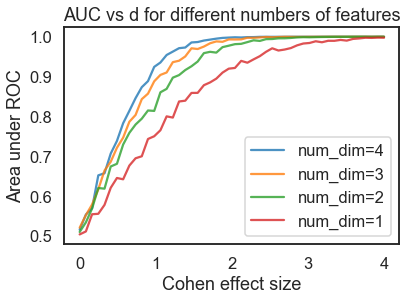

In [41]:
plot_auc_vs_d(res4, 'num_dim=4')
plot_auc_vs_d(res3, 'num_dim=3')
plot_auc_vs_d(res2, 'num_dim=2')
plot_auc_vs_d(res1, 'num_dim=1')
plt.title('AUC vs d for different numbers of features')
plt.legend();

With more features, the AUC gets better, assuming the features are independent.